Import Libraries

In [0]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from sklearn import metrics
from skimage.io import imread
from skimage import io, transform
from PIL import Image 
from model.3D_CNN import Model, Face, Context

Define Dataset

In [0]:
class CombineDataset(data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir,root_dir1, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.root_dir1=root_dir1


    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        label=self.landmarks_frame.iloc[idx, 1]
        y=convertLabel(label)
        
        X1 = []
        for i in range(1,6):
          
          img_name = os.path.join(self.root_dir, label,self.landmarks_frame.iloc[idx, 0].split('.wav')[0])

          image = Image.open(str(img_name)+'_'+str(i)+'.jpg')
          if self.transform is not None:
                image = self.transform(image)
          X1.append(image.squeeze_(0))
        
        X2 = []
        for i in range(1,6):
          img_name = os.path.join(self.root_dir1,label, self.landmarks_frame.iloc[idx, 0].split('.wav')[0])
          image = Image.open(str(img_name)+'_'+str(i)+'.jpg')
          if self.transform is not None:
                image = self.transform(image)
          X2.append(image.squeeze_(0))

        X1 = torch.stack(X1, dim=0).unsqueeze_(0)
        X2 = torch.stack(X2, dim=0).unsqueeze_(0)

        return X1,X2,y

In [0]:
def convertLabel(label):
    if(label=='Anger'):
        return 0
    if(label=='Disgust'):
        return 1
    if(label=='Fear'):
        return 2
    if(label=='Happy'):
        return 3
    if(label=='Neutral'):
        return 4     
    if(label=='Sad'):
        return 5
    if(label=='Surprise'):
        return 6

Define Train Function

In [0]:
def train(model, device, train_loader, epochs):
    # set model as training mode
    model.to(device)
    model.train()
    
    # Setup loss function and optimizer
    criterion=nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    loss_over_time = [] # to track the loss as the network trains
    average_over_time=[]
    
    for epoch in range(epochs):
      total = 0   # counting total trained sample in one epoch
      running_count = 0
      running_loss = 0.0
      running_corrects=0
        
      for batch_idx, (x1, x2, y) in enumerate(train_loader):
          # distribute data to device
          x1, x2, y = x1.to(device), x2.to(device), y.to(device).view(y.size(0), -1)

          x1=x1.squeeze(1)
          x1=x1.transpose(1,2)
          x1=x1.type(torch.cuda.FloatTensor)

          x2=x2.squeeze(1)
          x2=x2.transpose(1,2)
          x2=x2.type(torch.cuda.FloatTensor)

          optimizer.zero_grad()

          output = model(x1, x2)   # output has dim = (batch, number of classes)

          loss = criterion(output, y.squeeze(1))
          running_count += 1
          running_loss+=loss.item()

          # Compute accuracy
          output=output.cpu()
          y=y.cpu()
          _,pred = torch.max(output, 1)
          running_corrects += torch.sum(pred==y.squeeze(1)).item()
        
          total += y.size(0)     
            
          loss.backward()
          optimizer.step()

          # show information
          if batch_idx % 10 == 9:    # print every 10 batches
            loss_over_time.append(loss.item())
            average_over_time.append(100*running_corrects/total)

            print('Epoch: {}, Batch: {}, Avg. Loss: {}, average accuracy: {}%'.format(epoch + 1, batch_idx+1, running_loss/running_count,100*running_corrects/total))

    return loss_over_time, average_over_time

Define Model

In [0]:
model = Model(Face(),Context())

Define Train Dataloader

In [0]:
dataset = CombineDataset(csv_file='/csv/assignment_audio.csv',root_dir='/data/ImageData/training_face',root_dir1="/data/ImageData/training_background",
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

trainloader = DataLoader(dataset, batch_size=15,
                        shuffle=True, num_workers=8)

device = "cuda" if torch.cuda.is_available() else "cpu"

Training

In [0]:
loss,accuracy = train(model=model, device=device,train_loader=trainloader,epochs=20)

Epoch: 1, Batch: 10, Avg. Loss: 2.4436575889587404, average accuracy: 22.0%
Epoch: 1, Batch: 20, Avg. Loss: 2.2430825769901275, average accuracy: 18.666666666666668%
Epoch: 1, Batch: 30, Avg. Loss: 2.1311224063237506, average accuracy: 22.444444444444443%
Epoch: 1, Batch: 40, Avg. Loss: 2.0896933555603026, average accuracy: 23.666666666666668%
Epoch: 1, Batch: 50, Avg. Loss: 2.06985050201416, average accuracy: 22.933333333333334%
Epoch: 1, Batch: 60, Avg. Loss: 2.0378927032152814, average accuracy: 24.22222222222222%
Epoch: 1, Batch: 70, Avg. Loss: 2.01153438772474, average accuracy: 25.047619047619047%
Epoch: 1, Batch: 80, Avg. Loss: 2.005185128748417, average accuracy: 24.75%
Epoch: 1, Batch: 90, Avg. Loss: 1.9950891494750977, average accuracy: 24.444444444444443%
Epoch: 1, Batch: 100, Avg. Loss: 1.9805597865581512, average accuracy: 24.8%
Epoch: 1, Batch: 110, Avg. Loss: 1.9646020889282227, average accuracy: 25.333333333333332%
Epoch: 1, Batch: 120, Avg. Loss: 1.966189169883728, ave

Save Model Parameters

In [0]:
torch.save(model.state_dict(), "model/3D-CNN.pt")

Graph Result

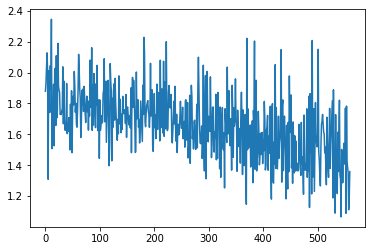

In [0]:
plt.plot(loss, label='Loss')

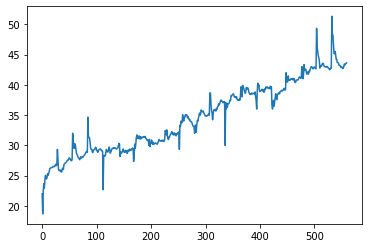

In [0]:
plt.plot(accuracy, label='Accuracy')

Define Evaluate Function

In [0]:
def evaluate(net):

    # set to evaluation mode
    net.eval()
    # running_correct
    running_corrects = 0
    total = 0

    for batch_idx, (x1, x2, y) in enumerate(test_loader):
        # transfer to the GPU
        x1, x2, y = x1.to(device), x2.to(device), y.to(device).view(y.size(0), -1)

        total += y.size(0)
        x1=x1.squeeze(1)
        x1=x1.transpose(1,2)
        x1=x1.type(torch.cuda.FloatTensor)

        x2=x2.squeeze(1)
        x2=x2.transpose(1,2)
        x2=x2.type(torch.cuda.FloatTensor)

        # perform prediction (no need to compute gradient)
        with torch.no_grad():
            outputs = net(x1, x2)
            _, pred = torch.max(outputs, 1)
            running_corrects += torch.sum(pred==y.squeeze(1)).item()
            
        print('Accuracy = {:.2f}%'.format(100*running_corrects/total))

        predicted_classes = torch.argmax(outputs, dim=1) 
        for i in y.squeeze(1).cpu().detach().numpy():
            y_true.append(i)
        for i in predicted_classes.cpu().detach().numpy():
            y_pred.append(i)

    print(metrics.confusion_matrix(y_true, y_pred))
    print(metrics.classification_report(y_true, y_pred, digits=3))


Define Test Dataloader

In [0]:
test_dataset = CombineDataset(csv_file='/csv/assignment_audio_validation.csv',root_dir='/data/ImageData/testing_face',root_dir1="/data/ImageData/testing_background",
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

test_loader = DataLoader(test_dataset, batch_size=15,
                        shuffle=True, num_workers=8)

Evaluate Model

In [0]:
device = 'cuda'
y_true = []
y_pred = []
evaluate(model)

Accuracy = 40.00%
15
15
Accuracy = 50.00%
30
30
Accuracy = 46.67%
45
45
Accuracy = 38.33%
60
60
Accuracy = 36.00%
75
75
Accuracy = 35.56%
90
90
Accuracy = 37.14%
105
105
Accuracy = 35.83%
120
120
Accuracy = 37.04%
135
135
Accuracy = 39.33%
150
150
Accuracy = 39.39%
165
165
Accuracy = 38.89%
180
180
Accuracy = 37.44%
195
195
Accuracy = 38.10%
210
210
Accuracy = 38.67%
225
225
Accuracy = 38.33%
240
240
Accuracy = 38.82%
255
255
Accuracy = 38.52%
270
270
Accuracy = 39.30%
285
285
Accuracy = 38.00%
300
300
Accuracy = 37.14%
315
315
Accuracy = 37.88%
330
330
Accuracy = 37.68%
345
345
Accuracy = 37.78%
360
360
Accuracy = 38.40%
375
375
Accuracy = 38.72%
390
390
Accuracy = 39.01%
405
405
Accuracy = 38.57%
420
420
Accuracy = 37.70%
435
435
Accuracy = 37.56%
450
450
Accuracy = 37.20%
465
465
Accuracy = 37.50%
480
480
Accuracy = 37.37%
495
495
Accuracy = 37.06%
510
510
Accuracy = 37.14%
525
525
Accuracy = 37.22%
540
540
Accuracy = 37.30%
555
555
Accuracy = 37.54%
570
570
Accuracy = 37.95%
585
58